In [1]:
import json
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
path = "data/images/"
seed = 42

In [3]:
B = 2
C = 20
S = 7

In [4]:
json_data = json.load(open("data/pascal_train2012.json"))

In [5]:
cats = json_data["categories"]
id_cat = []

for c in cats:
    id_cat.append([c["id"], c["name"]])
    
df_cats = pd.DataFrame(id_cat, columns=["category_id", "name"])

In [6]:
id_cat = {value-1:key for (value, key) in id_cat}

In [7]:
df_filename = pd.DataFrame(json_data["images"])
df_filename.columns = ["file_name", "height", "image_id", "width"]

df_bbox = pd.DataFrame(json_data["annotations"])

In [8]:
df = df_filename.merge(df_bbox, on="image_id")
df = df[df["ignore"] == 0]
df = df.drop(["area", "ignore", "iscrowd", "segmentation", "image_id"], axis=1)
df = df.merge(df_cats, on="category_id")

In [9]:
df.head()

,file_name,height,width,bbox,category_id,id,name
0,2008_000008.jpg,442,500,"[52, 86, 419, 334]",13,1,horse
1,2008_000141.jpg,333,500,"[93, 8, 407, 325]",13,69,horse
2,2008_000142.jpg,333,500,"[108, 74, 386, 259]",13,71,horse
3,2008_000371.jpg,333,500,"[188, 128, 186, 148]",13,229,horse
4,2008_000428.jpg,253,400,"[0, 42, 378, 195]",13,276,horse


In [10]:
grouped_data = []

grouped = df.groupby("file_name")
for name, group in grouped:
    val = [name, group["width"].values[0], group["height"].values[0], list(group["name"].values),
           list(group["bbox"].values), list(group["category_id"].values - 1)]
    grouped_data.append(val)
    
print(grouped_data[0])

['2008_000008.jpg', 500, 442, ['horse', 'person'], [[52, 86, 419, 334], [157, 43, 132, 124]], [12, 14]]


In [11]:
target_size = 224

for g in grouped_data:
    x_scale = target_size / g[1]
    y_scale = target_size / g[2]

    old_boxes = g[4]
    new_boxes = []

    for i in range(len(old_boxes)):
        (x, y, d_x, d_y) = old_boxes[i]

        x = int(round(x * x_scale))
        y = int(round(y * y_scale))
        d_x = int(round(d_x * x_scale))
        d_y = int(round(d_y * y_scale))
    
        new_boxes.append([x, y, d_x, d_y])
        
    g[4] = new_boxes
    
    # removing width and height
    del g[2]
    del g[1]

In [242]:
example = grouped_data[5]
example

['2008_000033.jpg', ['aeroplane'], [[46, 40, 167, 133]], [0]]

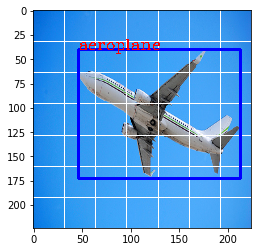

In [243]:
def read_img(img_str, target_size):
    img = cv2.imread(img_str, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size, target_size))
    return img

def draw_boxes(img, boxes):
    for i in range(len(boxes)):
        cv2.rectangle(img, (boxes[i][0], boxes[i][1]),
                      (boxes[i][0] + boxes[i][2], boxes[i][1] + boxes[i][3]), (0, 0, 255), 2)
    
    return img

def draw_grid(img, pixel_step):
    x = pixel_step
    y = pixel_step
    
    while x < img.shape[1]:
        cv2.line(img, (x, 0), (x, img.shape[0]), color=(255, 255, 255))
        x += pixel_step

    while y < img.shape[0]:
        cv2.line(img, (0, y), (img.shape[1], y), color=(255, 255, 255))
        y += pixel_step   
        
    return img

def draw_text(img, texts, locations):
    for text, loc in zip(texts, locations):
        cv2.putText(img, text, (loc[0], loc[1]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,0,0), 1)
    return img

img_str = path + example[0]
img = read_img(img_str, target_size)

img = draw_grid(img, int(np.ceil(target_size / S)))
img = draw_boxes(img, example[2])
img = draw_text(img, example[1], example[2])
plt.imshow(img)
plt.show()

In [15]:
grid_size = target_size / S

y_list = []

for data in grouped_data: 
    # For one grid element: [pc, c1, ..., cN, b1x, b1y, w1, h1, b2x, b2y, w2, h2]
    y = np.zeros((1, S, S, 5*B + C))

    boxes = data[2]
    classes = data[3]

    for i in range(len(boxes)):
        box = boxes[i]

        center_width = box[0] + box[2]/2
        center_height = box[1] + box[3]/2

        width_index = int(np.floor((center_width / target_size) * S))
        height_index = int(np.floor((center_height / target_size) * S))

        class_index = classes[i]

        # Normalize width and height by the enitre image size
        w = box[2] / target_size
        h = box[3] / target_size

        # Normalize bx and by according to the current grid position
        bx = (center_width - ((width_index / S) * target_size)) / grid_size
        by = (center_height - ((height_index / S) * target_size)) / grid_size
        
        y[:, width_index, height_index, class_index] = 1.0
        
        # Hardcoded for B=2
        if y[:, width_index, height_index, 20] == 0.0:
            y[:, width_index, height_index, 20] = 1.0
            y[:, width_index, height_index, 21] = bx
            y[:, width_index, height_index, 22] = by
            y[:, width_index, height_index, 23] = w
            y[:, width_index, height_index, 24] = h
        else:
            y[:, width_index, height_index, 25] = 1.0
            y[:, width_index, height_index, 26] = bx
            y[:, width_index, height_index, 27] = by
            y[:, width_index, height_index, 28] = w
            y[:, width_index, height_index, 29] = h

    y_list.append(y)
y = np.concatenate(y_list, axis=0)

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Removing adaptive avg pooling and fc
        pretrained_model = list(models.vgg16(pretrained='imagenet').children())[:-1]
        self.pretrained_model = nn.Sequential(*pretrained_model)
        
        self.fc = nn.Linear(512*7*7, 4096)
        self.fc_out = nn.Linear(4096, S*S*(5*B + C))
                              
    def forward(self, x):
        x = self.pretrained_model(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc_out(x)
        x = x.view(x.size(0), S, S, (5*B + C))
        x = F.relu(x)
        return x
    
    def change_freezing(self, mode=False):
        for param in self.pretrained_model.parameters():
            param.requires_grad = mode

In [17]:
class PascalData(Dataset):
    def __init__(self, data_list, y, lambda_indicator, target_size=target_size, path=path):
        self.target_size = target_size
        self.path = path
        
        self.lambda_indicator = torch.from_numpy(lambda_indicator).float().to(device)
        
        self.y = torch.from_numpy(y).float().to(device)
        self.file_list = [i[0] for i in data_list]      
        
        self.mean = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((1,1,3))
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_str = self.path + self.file_list[idx]
        
        img = read_img(img_str, self.target_size)
        img = img / 255.0
        img = (img - self.mean) / self.std
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img).float().to(device)
        return (img, self.y[idx,:], self.lambda_indicator[idx, :, :, :])

In [18]:
device = "cuda"
model = Model()
model = model.to(device)
model.change_freezing(False)

In [19]:
lambda_coord = 5
lambda_noobj = 0.5

lambda_indicator = (y > 0.0).astype(float)

lambda_indicator[:, :, :, 0:20][(lambda_indicator[:, :, :, 20] != 0.0) | 
                                (lambda_indicator[:, :, :, 25] != 0.0)] = 1.0

lambda_indicator[:, :, :, 20][lambda_indicator[:, :, :, 20] == 0.0] = lambda_noobj
lambda_indicator[:, :, :, 21] = lambda_indicator[:, :, :, 21]*lambda_coord
lambda_indicator[:, :, :, 22] = lambda_indicator[:, :, :, 22]*lambda_coord
lambda_indicator[:, :, :, 23] = lambda_indicator[:, :, :, 23]*lambda_coord
lambda_indicator[:, :, :, 24] = lambda_indicator[:, :, :, 24]*lambda_coord

lambda_indicator[:, :, :, 25][lambda_indicator[:, :, :, 25] == 0.0] = lambda_noobj
lambda_indicator[:, :, :, 26] = lambda_indicator[:, :, :, 26]*lambda_coord
lambda_indicator[:, :, :, 27] = lambda_indicator[:, :, :, 27]*lambda_coord
lambda_indicator[:, :, :, 28] = lambda_indicator[:, :, :, 28]*lambda_coord
lambda_indicator[:, :, :, 29] = lambda_indicator[:, :, :, 29]*lambda_coord

In [20]:
batch_size = 64
dataset = PascalData(grouped_data, y, lambda_indicator)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [21]:
def loss(y, y_hat, indicator):
    y[:,:,:,23] = torch.sqrt(y[:,:,:,23])
    y[:,:,:,24] = torch.sqrt(y[:,:,:,24])
    y[:,:,:,28] = torch.sqrt(y[:,:,:,28])
    y[:,:,:,29] = torch.sqrt(y[:,:,:,29])
    
    y_hat[:,:,:,23] = torch.sqrt(y_hat[:,:,:,23])
    y_hat[:,:,:,24] = torch.sqrt(y_hat[:,:,:,24])
    y_hat[:,:,:,28] = torch.sqrt(y_hat[:,:,:,28])
    y_hat[:,:,:,29] = torch.sqrt(y_hat[:,:,:,29])
    
    return torch.sum(indicator * ((y - y_hat)*(y - y_hat)))

In [22]:
n_epochs = 10
lr = 2e-5
wd = 0.0005

In [23]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [35]:
torch.manual_seed(seed)
for epoch in range(0, n_epochs):
    model.train()
    train_loss = 0
    for _, (x_i, y_i, indicator_i) in enumerate(train_loader):
        model.zero_grad()
        y_hat = model(x_i)
        batch_loss = loss(y_i, y_hat, indicator_i)

        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss / batch_size
    train_loss = np.round((train_loss/len(train_loader)).detach().cpu().numpy(), 6)
    print(train_loss)

2.708931
2.61253
2.541004
2.381237
2.297208
2.25292
2.216855
2.191572
2.109555
2.017268


In [275]:
index = 2
(x_i, _, _) = dataset[index]

y_hat = model(x_i.reshape(1, 3, target_size, target_size))
y_hat = y_hat.detach().cpu().numpy()

In [276]:
output_bb = []
class_id_list = []

pc_threshold = 0.25

for i in range(S):
    for j in range(S):
        found_object = False
        
        for b in range(B):
            pc = y_hat[:, i, j, 20 + 5*b]

            if pc < pc_threshold:
                continue
            else:
                found_object = True
        
            box_width = y_hat[:, i, j, 23 + 5*b]*target_size
            box_height = y_hat[:, i, j, 24 + 5*b]*target_size 
            
            bx = i*grid_size + y_hat[:, i, j, 21 + 5*b]*grid_size - box_width/2
            by = j*grid_size + y_hat[:, i, j, 22 + 5*b]*grid_size - box_height/2   
            
            output_bb.append([pc[0], bx[0], by[0], box_width[0], box_height[0]])
        
        if found_object:
            class_id_list.append(np.argmax(y_hat[:, i, j, 0:20][0,:]))

class_name_list = [id_cat[c] for c in class_id_list]

In [277]:
for i in range(len(output_bb)):
    output_bb[i].insert(1, (class_name_list[i]))
    output_bb[i].insert(1, class_id_list[i])
    
output_bb = sorted(output_bb, key = lambda x: x[0], reverse=True)

In [278]:
output_bb

[[1.0054612, 11, 'dog', 61.498215, -1.045845, 115.612274, 157.58258],
 [0.8672104, 11, 'dog', 73.09596, 50.048233, 76.06098, 150.30751]]

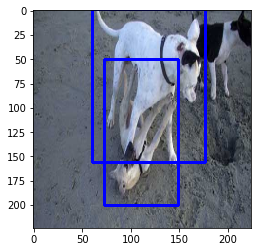

In [279]:
img_file = dataset.file_list[index]
img_str = path + img_file

img = read_img(img_str, target_size)
img = draw_boxes(img, [bb[3:] for bb in output_bb])
plt.imshow(img)
plt.show()

In [280]:
def calc_iou(box_a, box_b):
    # Coverting boxes to (x1, y1) and (x2, y2)
    box_a[2] = box_a[2] + box_a[0]
    box_a[3] = box_a[3] + box_a[1]
    
    box_b[2] = box_b[2] + box_b[0]
    box_b[3] = box_b[3] + box_b[1]
    
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[2], box_b[2])
    y_b = min(box_a[3], box_b[3])
 
    # Compute the area of intersection
    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
 
    # Compute the area of the prediction and ground-truth
    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
 
    # IOU
    iou = inter_area / (box_a_area + box_b_area - inter_area + 1e-8)
 
    return iou

In [281]:
def non_max_suppression(output_bb):
    filtered_bb = []

    while len(output_bb) != 0:
        best_bb = output_bb.pop(0)
        filtered_bb.append(best_bb)

        remove_items = []
        for j in range(len(output_bb)):
            if calc_iou(best_bb[3:], output_bb[j][3:]) > 0.5:
                remove_items.append(output_bb[j])

        output_bb = [bb for bb in output_bb if bb not in remove_items]
        
    return filtered_bb

In [282]:
filtered_bb = non_max_suppression(output_bb)

In [283]:
filtered_bb

[[1.0054612, 11, 'dog', 61.498215, -1.045845, 115.612274, 157.58258],
 [0.8672104, 11, 'dog', 73.09596, 50.048233, 76.06098, 150.30751]]

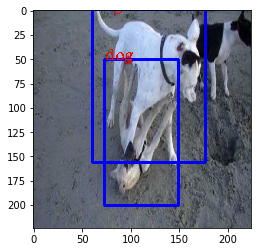

In [284]:
img_file = dataset.file_list[index]
img_str = path + img_file

img = read_img(img_str, target_size)
img = draw_boxes(img, [bb[3:] for bb in filtered_bb])
img = draw_text(img, [bb[2] for bb in filtered_bb], [bb[3:] for bb in filtered_bb])

plt.imshow(img)
plt.show()